In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from datetime import datetime
from scipy.linalg import eig

In [8]:
df_data = pd.read_excel("bond_close.xlsx")
df_data.head(1)

,ISIN,Issue Date,Maturity Date,Coupon,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,2024-01-15 00:00:00,2024-01-16 00:00:00,2024-01-17 00:00:00,2024-01-18 00:00:00,2024-01-19 00:00:00
0,CA135087B451,7/2/2013,6/1/2024,0.025,99.037,99.04,99.053,99.064,99.09,99.111,99.069,99.076,99.099,99.113


In [18]:
col_rename = ['ISIN', 'Issue Date', 'Maturity Date', 'Coupon rate']

for i in range(10):
    col_rename.append( str(datetime.date(df_raw.columns[4:][i])) )

df_data.columns = col_rename
df_data['Maturity Date'] = pd.to_datetime(df_data['Maturity Date'])
df_data['Issue Date'] = pd.to_datetime(df_data['Issue Date'])

bond_portfolio = ['CA135087N910', 'CA135087P659', 'CA135087K940', 'CA135087L518','CA135087L930', 'CA135087M847', 'CA135087N837', 'CA135087P576','CA135087Q491', 'CA135087Q988']
YTM_index = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
df_bonds = df_data.loc[df_data['ISIN'].isin(bond_portfolio)]
df_bonds = df_bonds.sort_values(by = ['Maturity Date']).reset_index(drop=True)
df_bonds['time_to_maturity'] = YTM_index

dates=list(df_bonds.columns[4:-1])

In [48]:
df_bonds

,ISIN,Issue Date,Maturity Date,Coupon rate,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,time_to_maturity
0,CA135087N910,2022-05-24,2024-08-01,0.0275,98.818,98.822,98.835,98.841,98.878,98.909,98.839,98.832,98.856,98.860,0.5
1,CA135087P659,2022-11-02,2025-02-01,0.0375,99.130,99.135,99.146,99.127,99.242,99.277,99.111,99.029,99.014,99.025,1.0
2,CA135087K940,2020-04-03,2025-09-01,0.0050,94.340,94.370,94.380,94.430,94.490,94.490,94.420,94.250,94.240,94.220,1.5
3,CA135087L518,2020-10-09,2026-03-01,0.0025,92.862,92.860,92.844,92.856,93.023,93.008,92.796,92.570,92.546,92.545,2.0
4,CA135087L930,2021-04-16,2026-09-01,0.0100,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070,2.5
5,CA135087M847,2021-10-15,2027-03-01,0.0125,93.282,93.301,93.245,93.186,93.467,93.493,93.141,92.856,92.753,92.764,3.0
6,CA135087N837,2022-05-13,2027-09-01,0.0275,97.580,97.591,97.603,97.520,97.740,97.772,97.441,97.092,96.956,96.947,3.5
7,CA135087P576,2022-10-21,2028-03-01,0.0350,100.500,100.480,100.439,100.328,100.637,100.673,100.220,99.834,99.662,99.623,4.0
8,CA135087Q491,2023-04-21,2028-09-01,0.0325,99.740,99.720,99.720,99.550,99.880,99.910,99.440,98.990,98.810,98.770,4.5
9,CA135087Q988,2023-10-13,2029-03-01,0.0400,103.406,103.380,103.279,103.132,103.542,103.552,102.974,102.483,102.279,102.242,5.0


In [20]:
def get_zero_coupon_rate(price, T, notional):
    return (-np.log(price/notional)/T)

def get_bond_YTM(price, coupon_rate, T, notional):
    coupon_payment = coupon_rate * notional * 0.5
    bond_to_maturity = YTM_index[:YTM_index.index(T)]
    YTM = lambda x: sum([coupon_payment * np.exp(-x * t) for t in bond_to_maturity]) +((notional + coupon_payment) * np.exp(-x * T)) - price
    return optimize.newton(YTM, 0.02)

def get_bond_spot_rate(spot_rate, price, coupon_rate, T, notional):
    coupon_payment = coupon_rate * notional * 0.5
    if T == 0.5:
        zero_coupon_rate=get_zero_coupon_rate(price, T, notional + coupon_payment)
        spot_rate.append(zero_coupon_rate)
    else:
        value = price
        discounted_coupon_total = 0
        for t in range(len(spot_rate)):
            spot_rate_t = spot_rate[t]
            discounted_coupon_total += coupon_payment * np.exp(-spot_rate_t * YTM_index[t])
        value -= discounted_coupon_total
        spot_rate.append(-(np.log(value/(notional+coupon_payment))/T) )
    return spot_rate


In [21]:
# YTM Calculation
YTM_curve = {}
Yield_bond_date = {}

for i in range(len(bond_portfolio)):
    bond_YTM_yield = []
    bond_price = list(df_bonds.iloc[i,4:-1])
    time_to_maturity = df_bonds.iloc[i,-1]
    coupon_rate = df_bonds.iloc[i,3]
    
    for price_t in bond_price:
        bond_YTM_yield.append(get_bond_YTM(price_t, coupon_rate, time_to_maturity, 100))

    YTM_curve[bond_portfolio[i]] = bond_YTM_yield.copy()


for i in range(len(dates)):
    Yield_bond_date[dates[i]] = []
    for name in YTM_curve:
        Yield_bond_date[dates[i]].append(YTM_curve[name][i])

In [22]:
# spot rate calculation
spot_rate_curve = {}
coupon_rate = list(df_bonds['Coupon rate'])

for t in dates:
    prices_t = list(df_bonds[t])
    spot_rate = []
    
    for i in range(len(dates)):
        spot_rate = get_bond_spot_rate(spot_rate, prices_t[i], coupon_rate[i], YTM_index[i],100).copy()
    spot_rate_curve[t] = spot_rate

In [23]:
# forward rate calculation
forward_curve_date = {}
t0 = 1
time_step = [2, 3, 4, 5]
for t in dates:
    spot_curve = spot_rate_curve[t]
    forward_curve = np.zeros(len(time_step))
    for i in range(len(time_step)):
        forward_curve[i] = (spot_curve[time_step[i]*2-1] * time_step[i]-spot_curve[t0])/(time_step[i]-t0)
    forward_curve_date[t] = forward_curve

In [24]:
for i in range(len(bond_portfolio)):
    print("YTM for {}: {}".format(bond_portfolio[i], YTM_curve[bond_portfolio[i]]))

YTM for CA135087N910: [0.051093476081667304, 0.05101252080944409, 0.05074943880336835, 0.05062802800991139, 0.04987949093594475, 0.04925255387225777, 0.050668497455481284, 0.05081014696406747, 0.05032453326737539, 0.05024360911352754]
YTM for CA135087P659: [0.04597217313156185, 0.045921265080579886, 0.045809276447579574, 0.04600271920037689, 0.0448324505976451, 0.0444765522907986, 0.04616564725412653, 0.04700106847893237, 0.04715396462286029, 0.04704183850892712]
YTM for CA135087K940: [0.04393564991556593, 0.0437231375836453, 0.043652315173644575, 0.04329831580669561, 0.04287376425889891, 0.04287376425889891, 0.04336910066098856, 0.04457359320216014, 0.044644513443709816, 0.04478637653850103]
YTM for CA135087L518: [0.03959720909768606, 0.0396079989624866, 0.03969432625744732, 0.03962957939007394, 0.038729387285290594, 0.03881017670184209, 0.03995339753465958, 0.0411749971596447, 0.041304899888312485, 0.04131031323389083]
YTM for CA135087L930: [0.0373058873006444, 0.037392386418300304, 

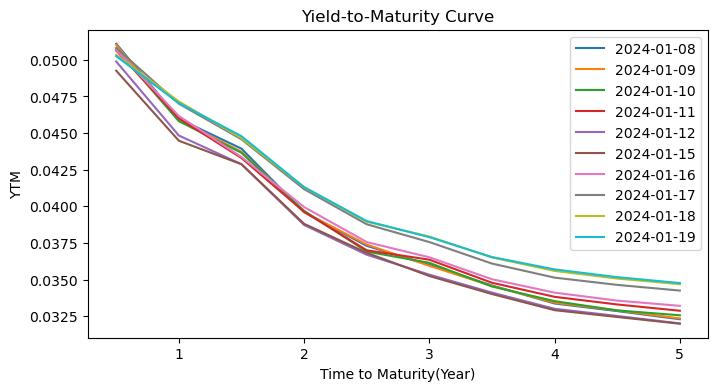

In [25]:
# Plot YTM curve
fig = plt.figure(figsize = (8, 4))
for date in dates:
    plt.plot(YTM_index, Yield_bond_date[date], label = date)

plt.title("Yield-to-Maturity Curve")
plt.xlabel("Time to Maturity(Year)")
plt.ylabel("YTM")
plt.legend()
plt.show()
fig.savefig('YTM CURVE.jpg')

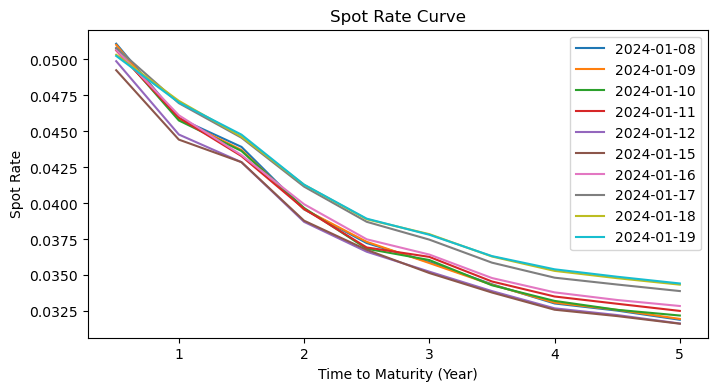

In [26]:
# Plot spot rate
fig=plt.figure(figsize = (8, 4))

for date in dates:
    plt.plot(YTM_index, spot_rate_curve[date], label = date)

plt.title("Spot Rate Curve")
plt.xlabel("Time to Maturity (Year)")
plt.ylabel("Spot Rate")
plt.legend()
plt.show()
fig.savefig('SPOT RATE CURVE.jpg')

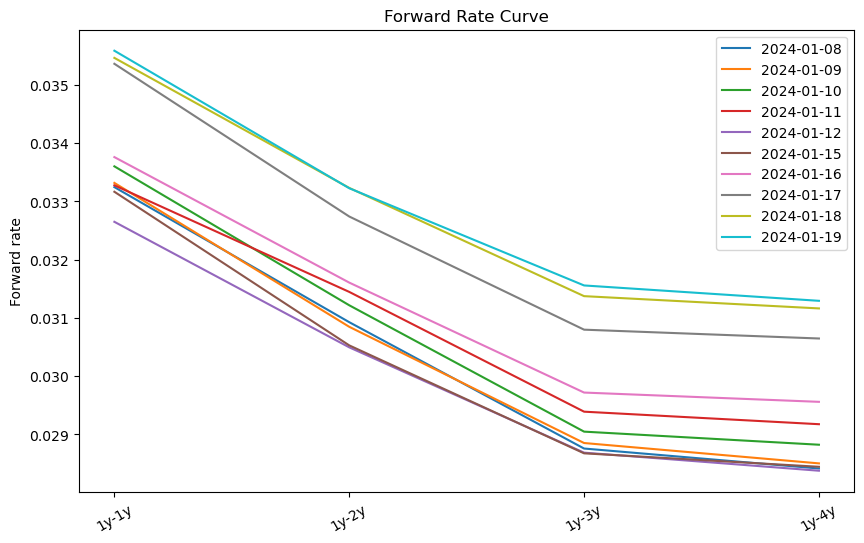

In [52]:
# Plot forward rate
fig=plt.figure(figsize = (10, 6))
labels = ['1y-1y', '1y-2y', '1y-3y', '1y-4y']
for date in dates:
    plt.plot(time_step, forward_curve_date[date], label = date)

plt.title("Forward Rate Curve")
plt.ylabel("Forward rate")
plt.xticks(time_step, labels, rotation=30)
plt.legend(loc='best')
plt.show()
fig.savefig('FORWARD RATE CURVE.jpg')

In [31]:
# Covariance matrices
yield_matrix = np.zeros([5, 9])
forward_matrix = np.zeros([4, 9])

for i in range(5):
    for j in range(9):
        yield_matrix[i,j] = np.log(Yield_bond_date[dates[j+1]][2*i+1] / Yield_bond_date[dates[j]][2*i+1])


for i in range(4):
    for j in range(9):
        forward_matrix[i,j] = np.log(forward_curve_date[dates[j+1]][i] / forward_curve_date[dates[j]][i])
        
        
yield_matrix_ = (yield_matrix.T - np.mean(yield_matrix.T, axis = 0)).T
forward_matrix_ = (forward_matrix.T - np.mean(forward_matrix.T, axis = 0)).T

In [32]:
Yield_cov_matrix = np.cov(yield_matrix_)
Forward_cov_matrix = np.cov(forward_matrix_)

In [33]:
Yield_cov_matrix

array([[0.00030261, 0.00026086, 0.00031278, 0.0003005 , 0.00031372],
       [0.00026086, 0.00026253, 0.00028992, 0.00027504, 0.00029001],
       [0.00031278, 0.00028992, 0.00034398, 0.00032675, 0.00034417],
       [0.0003005 , 0.00027504, 0.00032675, 0.00031449, 0.00032846],
       [0.00031372, 0.00029001, 0.00034417, 0.00032846, 0.00034523]])

In [35]:
Forward_cov_matrix

array([[0.00034387, 0.00029731, 0.00025826, 0.00028005],
       [0.00029731, 0.00040594, 0.00036707, 0.00039488],
       [0.00025826, 0.00036707, 0.00034389, 0.00036279],
       [0.00028005, 0.00039488, 0.00036279, 0.00038821]])

In [36]:
eigenvalue_yield, eigenvector_yield = eig(Yield_cov_matrix)
eigenvalue_forward, eigenvector_forward = eig(Forward_cov_matrix)

In [55]:
print(eigenvalue_yield.real[0])
print(eigenvalue_yield.real[0] / np.sum(eigenvalue_yield.real))
print(eigenvector_yield[:,0])

0.0015360286741313513
0.9790862424445828
[-0.43476003 -0.40157809 -0.47190025 -0.45080555 -0.47307851]


In [56]:
print(eigenvalue_forward.real[0])
print(eigenvalue_forward.real[0] / np.sum(eigenvalue_forward.real))
print(eigenvector_forward[:,0])

0.001360264718074794
0.9179129655968009
[0.42931645 0.54192281 0.49325049 0.52793087]


In [57]:
PC1 = eigenvalue_yield.real[0] * eigenvector_yield[:,0]
PC2 = eigenvalue_yield.real[1] * eigenvector_yield[:,1]
print(PC1)
print(PC2)

[-0.0006678  -0.00061684 -0.00072485 -0.00069245 -0.00072666]
[-1.33673414e-05  1.62933124e-05  6.43777926e-07 -2.23694463e-06
 -5.66996921e-08]
